## Map stations

In [1]:
import os
import zipfile
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import csv
from datetime import datetime
import numpy as np
from pyproj import Proj
%run Meteo_utils.ipynb

In [2]:
os.listdir('data')

['.DS_Store',
 '07-HGPT-MT-07.- Estacion Aeropuerto-20210505T205931Z-001.zip',
 'Estaciones_meteorologicas.csv',
 'Estaciones_meteorologicas_SW.csv',
 '02-HGPT-MT-06.- Estacion Baños-20210426T162523Z-001.zip',
 'Aeropuerto_5min.csv',
 '07-HGPT-MT-07-EstacionAeropuerto.csv',
 'Inventario Estaciones Meteo.xls',
 '.ipynb_checkpoints',
 'Estaciones_meteorologicas_SW.numbers',
 'Aeropuerto_1min.csv']

In [43]:
df = pd.read_csv('data/Estaciones_meteorologicas.csv')
df.head()

,fuente,numero,codigo,nombre,tipo,provincia,estado,fecha_instalacion,latitud,longitud,parametros_medicion
0,esta_inamhi,1,M0029,BAÑOS,CP,TUNGURAHUA,FUNCIONANDO,20-jun-62,12329.0,782505.0,"Temperatura Max, temperatura Min, Temperatura,..."
1,esta_inamhi,2,M0258,QUEROCHACA(UTA),CP,TUNGURAHUA,FUNCIONANDO,2-nov-85,12202.0,783620.0,"Temperatura Max, temperatura Min, Temperatura,..."
2,esta_inamhi,3,M1069,CALAMACA CONVENIO INAMHI HCPT,CP,TUNGURAHUA,FUNCIONANDO,4-jul-88,11634.0,784908.0,"Temperatura Max, temperatura Min, Temperatura,..."
3,esta_inamhi,4,M0126,PATATE,CO,TUNGURAHUA,FUNCIONANDO,1-may-63,11801.0,783000.0,"Temperatura Max, temperatura Min, Temperatura,..."
4,esta_inamhi,5,M0127,PILLARO,CO,TUNGURAHUA,FUNCIONANDO,1-Dec-63,11010.0,783310.0,"Temperatura Max, temperatura Min, Temperatura,..."


In [44]:
df.fuente.unique()

array(['esta_inamhi', 'esta_hgpt', 'esta_hgpt_sen'], dtype=object)

In [25]:
# Conversion from UTM to degrees
# https://ocefpaf.github.io/python4oceanographers/blog/2013/12/16/utm/
# EPSG:32717 (UTM 17S) (copy Proj4 format)
north = Proj("+proj=utm +zone=17 +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
south = Proj("+proj=utm +zone=17 +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
df['lon_deg'] = np.nan 
df['lat_deg'] = np.nan 

In [79]:
# Convert DMS coords to DD
def latDD(x):
    D = int(str(x)[0:1])
    M = int(str(x)[1:3])
    S = int(str(int(x))[3:])
    DD = -(D + float(M)/60 + float(S)/3600)
    return DD
def lonDD(x):
    D = int(str(x)[0:2])
    M = int(str(x)[2:4])
    S = int(str(int(x))[4:])
    DD = -(D + float(M)/60 + float(S)/3600)
    return DD

In [80]:
# UTM info : http://geokov.com/education/utm.aspx
# Northing coordinates use Equator as reference. For NH, Equator= 0. For SH , Equator = 10.000.000
# Easting coordinates use the false origin 500000 meters to the west of the central meridian of the UTM zone

# ESTA INAMHI data had lat = xxxS and long = xxxW 
## 17N
df.loc[df['fuente'] != 'esta_inamhi','lon_deg'], df.loc[df['fuente'] != 'esta_inamhi','lat_deg']= south(df[df['fuente'] != 'esta_inamhi']['longitud'].values, 
                                                df[df['fuente'] != 'esta_inamhi']['latitud'].values, inverse=True)

## 17S
df.loc[df['fuente'] == 'esta_inamhi','lon_deg'] =  [lonDD(x) for x in df[df['fuente'] == 'esta_inamhi']['longitud'].values]
df.loc[df['fuente'] == 'esta_inamhi','lat_deg']= [latDD(x) for x in df[df['fuente'] == 'esta_inamhi']['latitud'].values]
                                                
                               

In [82]:
df['lon_deg'] = df['lon_deg'].replace({float("inf"): np.nan})  
df['lat_deg'] = df['lat_deg'].replace({float("inf"): np.nan})

In [16]:
### There is a problem with the coordinates. I can extract the coordinates from ESTA_INAMHI but not form the other 2. UTM format

In [83]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df['lon_deg'], df['lat_deg']))

In [84]:
gdf = gdf.set_crs(epsg=4326)

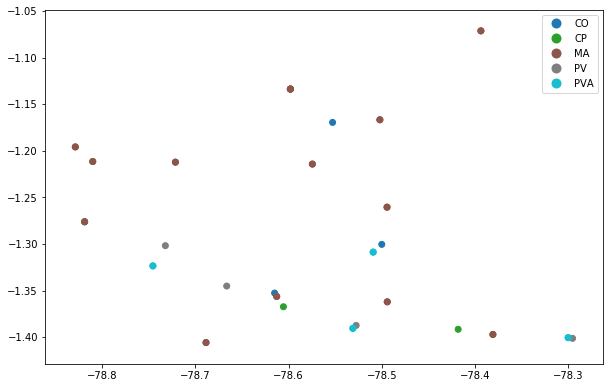

In [89]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
SA = world.query('name == "Ecuador"')
gdf4326 = gdf.to_crs(world.crs)

fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
#SA.plot(ax=ax, color='white', edgecolor='black')
gdf4326.plot(ax=ax, column = 'tipo', legend =True)
# for i in range(df.shape[0]):
#     plt.text(x=gdf4326.lon_deg[i]+0.1,y=gdf4326.lat_deg[i]+0.1,s=gdf4326.nombre[i], 
#           fontdict=dict(color='black',size=10),
#           bbox=dict(facecolor='yellow',alpha=0.5))

plt.show()

In [86]:
df[df.nombre.str.match('^[Bb][Aa][Ññ][Oo][Ss]')].drop(columns ='parametros_medicion')

,fuente,numero,codigo,nombre,tipo,provincia,estado,fecha_instalacion,latitud,longitud,lon_deg,lat_deg,geometry
0,esta_inamhi,1,M0029,BAÑOS,CP,TUNGURAHUA,FUNCIONANDO,20-jun-62,12329.0,782505.0,-78.418056,-1.391389,POINT (-78.41806 -1.39139)
16,esta_hgpt,6,HGPT_MT-0006,Baños,MA,TUNGURAHUA,FUNCIONANDO,February-13,9845439.0,791471.0,-78.380768,-1.396889,POINT (-78.38077 -1.39689)
35,esta_hgpt_sen,6,HGPT_MT-0006,Baños,MA,TUNGURAHUA,FUNCIONANDO,February-13,9845439.0,791471.0,-78.380768,-1.396889,POINT (-78.38077 -1.39689)
